<font face="Calibri" size="2"> <i>SBAE - Notebook Series - Part II, version 0.1,  June 2022. Andreas Vollrath, UN-Food and Agricultural Organization, Rome</i>
</font>

![title](images/header.png)

# II - Sample Design 
### Creation of point samples for subsequent analysis
-------

The Sample-based Area Estimation is based on a set of points for a given area of interest (AOI). There are different ways of creating a set of points, such as: 

- systematic, 
- random systematic,
- purely random or
- stratifed random.

In addition, the distribution of the points is defined by some type of underlying geometry. This can be some regular geometry, referred to as **grid** or a **layer of strata** such as a land cover map for example. Regular grids can be generated in the follwoing forms:

- square
- triangle
- hexagons

This notebook takes you through the process of generating such a set of sample points with the above mentioned options.

### Import libs

*Execute only*

In [1]:
import time
from datetime import datetime as dt
import matplotlib.pyplot as plt

import ee
import geemap
import geopandas as gpd
from sampling_handler.sampling import grid

# initialize EE    
try:
    ee.Initialize()
except:
    ee.Authenticate()
    ee.Initialize()

### 1 - Create (semi-) regular sample points based on squared grid cells


##### ***Introduction***
In this part we will cover the **systematic** and **random systematic** sample point creation. 
The underlying routine will create a **regular grid** of a given size over the given AOI. 

Based on this, there are 2 options to create a point layer, i.e. using the center point of each grid cell, or using a single random location within each grid cell. 

When creating samples, one important consideration is the projection used. Projections always exhibit distortions with regard to the actual sphere-like shape of the Earth. As our aim is to give each sample the same weight in terms of area representativeness, we shall select a projection that is optimised for **equal area**. In the table below you can find some examples of global equal area projections to select from. The information is taken from an article from Yildrim & Kaya 2008 and can be found [here](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3790990/#:~:text=The%20level%20of%20distortion%20can,compared%20to%20equal%2Darea%20maps). **Note** that the commonly used Lat/Lon projection (EPSG:4326) **does** contain distortions that shall be avoided.

| **Projection**    | **Code**       |
| -------------     |----------------|
| Behrmann          | ESRI:54017     | 
| Bonne             | ESRI:54024     | 
| Sinusoidal        | ESRI:54008     |

#### 1.1 - Define input variables

4 input variables need to be selected:

- Projection (as epsg/esri code)
- AOI (either as Country Name, Earth Engine Feature Collection, or geopandas readable vector file, i.e. shapefile, geopackage, geojson etc)
- Grid size (length of 1 border of the squared grid cell)
- Sampling strategy (either random for random systematic, or systematic)

In [2]:
# Define the Area of Interest 
#can be both, a EE FeatureCollection, or a geopandas readable file format)

# Example Country case, using FAO's GAUL boundaries
country = 'Kenya'   # Buhweju region in Uganda
aoi = ee.FeatureCollection("FAO/GAUL/2015/level1").filter(ee.Filter.eq('ADM0_NAME', country)) # here any feature collection can be selected

# Example using a shapefile (uncomment and adapt path)
#aoi = gpd.read_file('my_aoi_file.shp')

#### 1.2 - Create grid cells and sample points for a squared grid

In [3]:
# Define the grid size
grid_size = 20000                  # in metres
sampling_strategy = 'systematic'  # either 'random' or 'systematic'

# Define the projection to create the grid
projection = 'ESRI:54017'    # Behrmanns equal area

# Generate the grid
squared_grid_cells, squared_samples_gdf = grid.squared_grid(aoi, grid_size, projection, sampling_strategy)

INFO: Preparing AOI.
INFO: Creating grid cells.
INFO: Creating sampling points.
INFO: Adding a unique point ID...
INFO: Remove points outside AOI...
INFO: Final sampling grid consists of 1451 points.


#### 1.3 - Plot the results

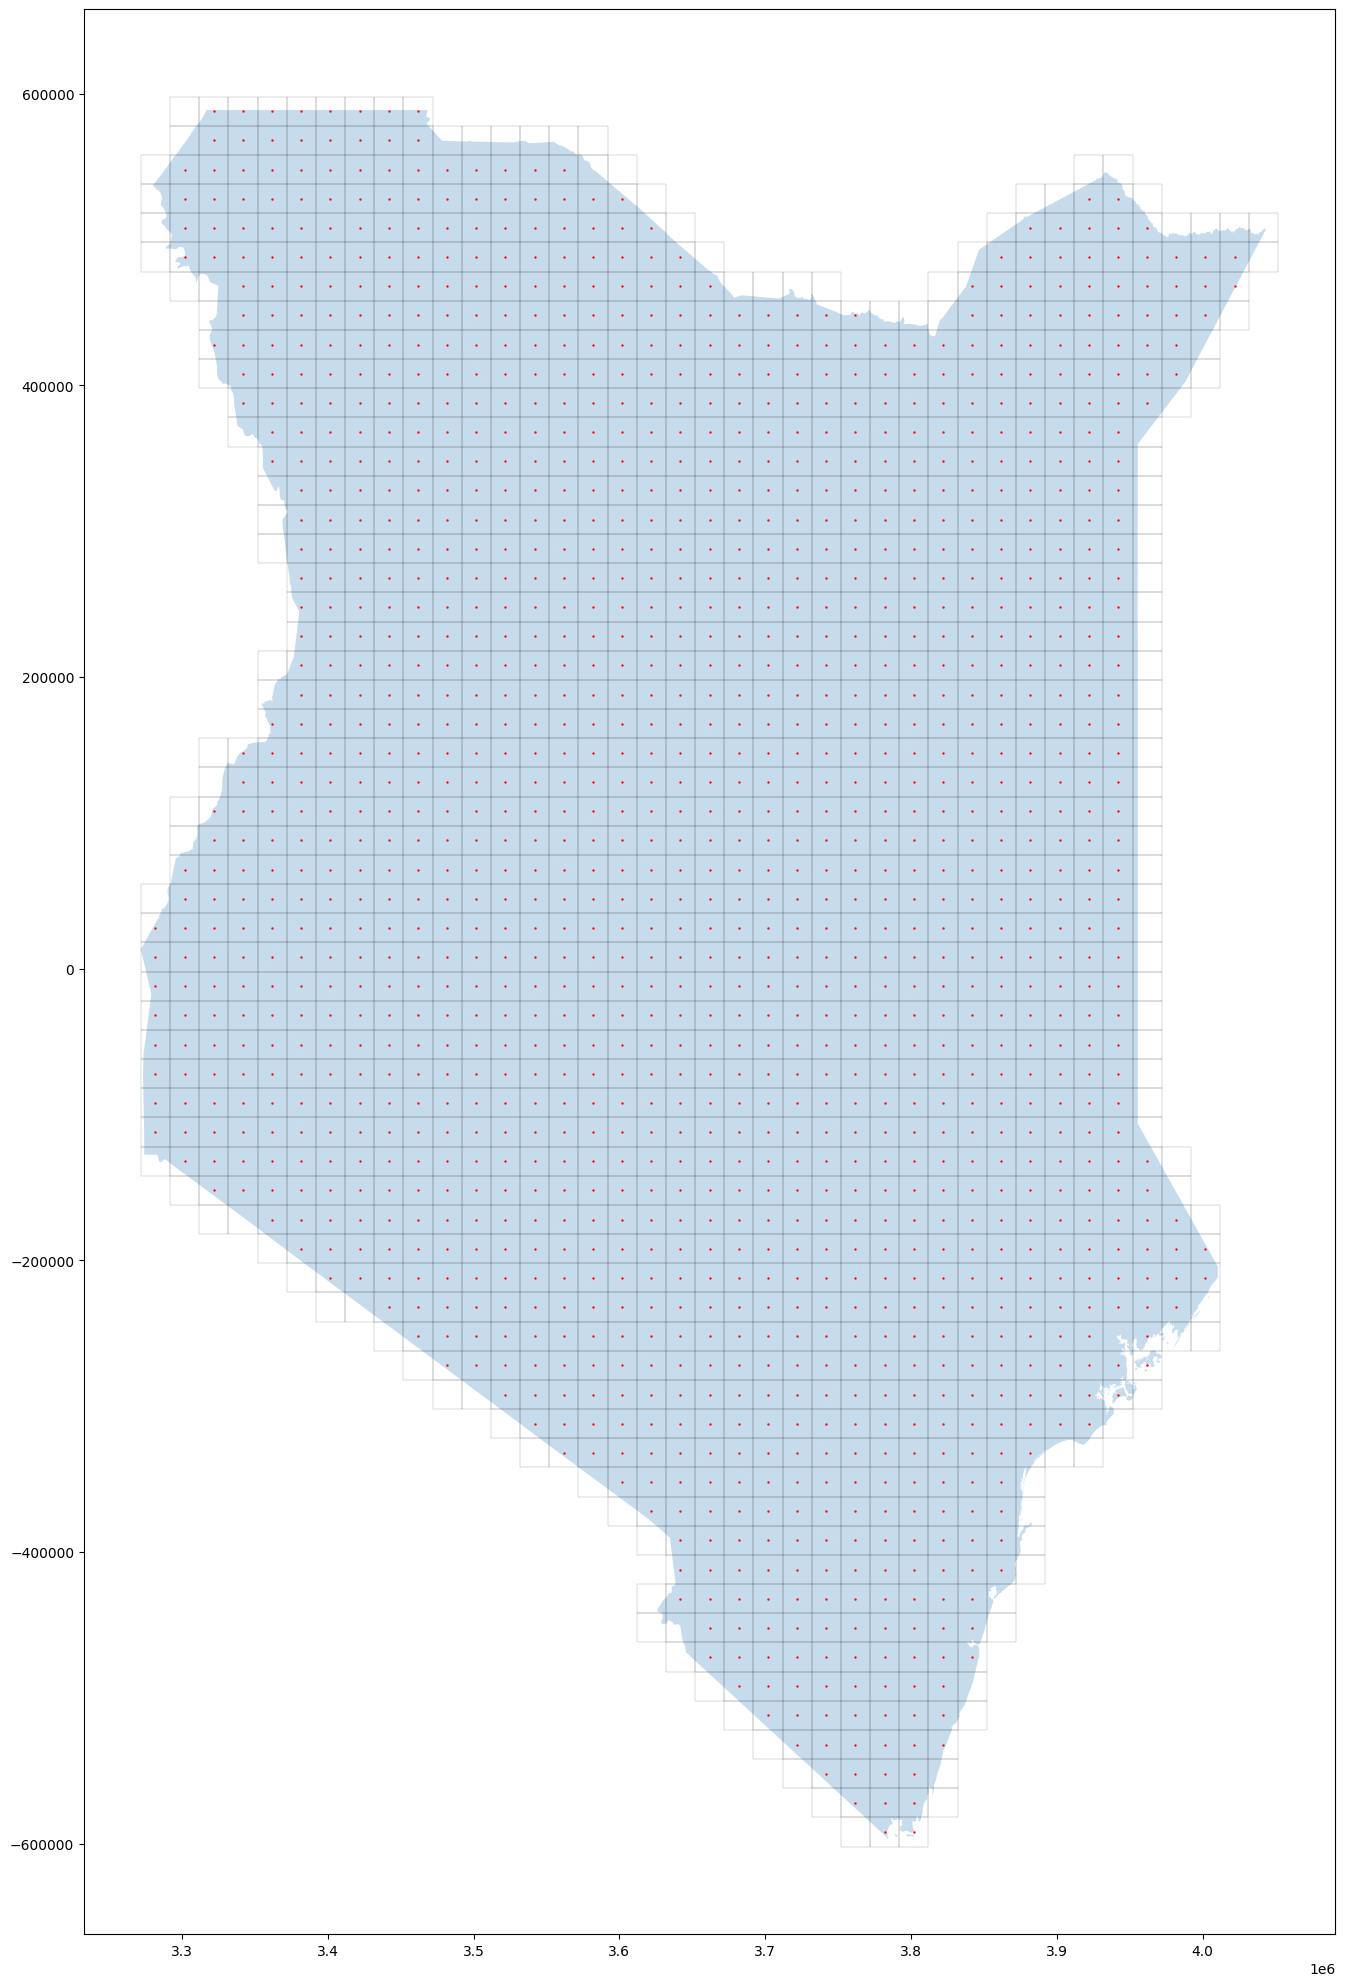

In [4]:
grid.plot_samples(aoi, squared_samples_gdf, squared_grid_cells)

### 2 - Create (semi-) regular sample points based on a hexagonal grid

***Why Hexagons?***

Hexagons have a couple of advantages as compared ot squared grid cells. Foremost, they reduce the error on area, but they also do assure that each point within the grid cell is mre or less at the same distance to the centre. Indeed, the ideal shape under that criteria would be a circle. It is however not possible to create a consistent grid of circles. The hexagon is the shape of polygon that comes closest to this criteria, while being able to provide a consistent grid.

***Discrete Global Grid System (DGGS)***

A Discrete Global Grid System (DGGS) is a series of discrete global grids, usually consisting of increasingly finer resolution grids. 

***Usage***

This notebook provides a simplified interface to the dggrid library from [Southern Oregon University](https://www.discreteglobalgrids.org/software/). 

It should be noted that the DGGRID ha a **fixed set of resolutions** that should be selected from column *res* in the below table (You need to check the manual for other resolutions if you select a different projection than the ISEA3H)

For advanced usage it is recommended to read the [manual](https://webpages.sou.edu/~sahrk/docs/dggridManualV70.pdf).

![title](images/dggrid_isea3h_ap3_res_table.png)


#### 2.1 - Create hexagonal grid

In [5]:
hex_grid_cells, hex_samples_gdf = grid.hexagonal_grid(
    aoi=aoi,                           # Area of interest
    resolution=11,                      # refers to the resolution of the grid
    sampling_strategy='systematic',    # choices are 'random' or 'systematic'
    centroid_crs="ESRI:54017",         # defines in which projection your centroids are created from the hexagons
    outcrs='EPSG:4326'                 # projection of the output data
)

INFO: Preparing AOI.
INFO: Creating hexagonal grid...
INFO: Time elapsed: 0:01:08.254325
INFO: Creating centroids based on Behrmann's equal area projection...


#### 2.2 Plot grid and grid cells

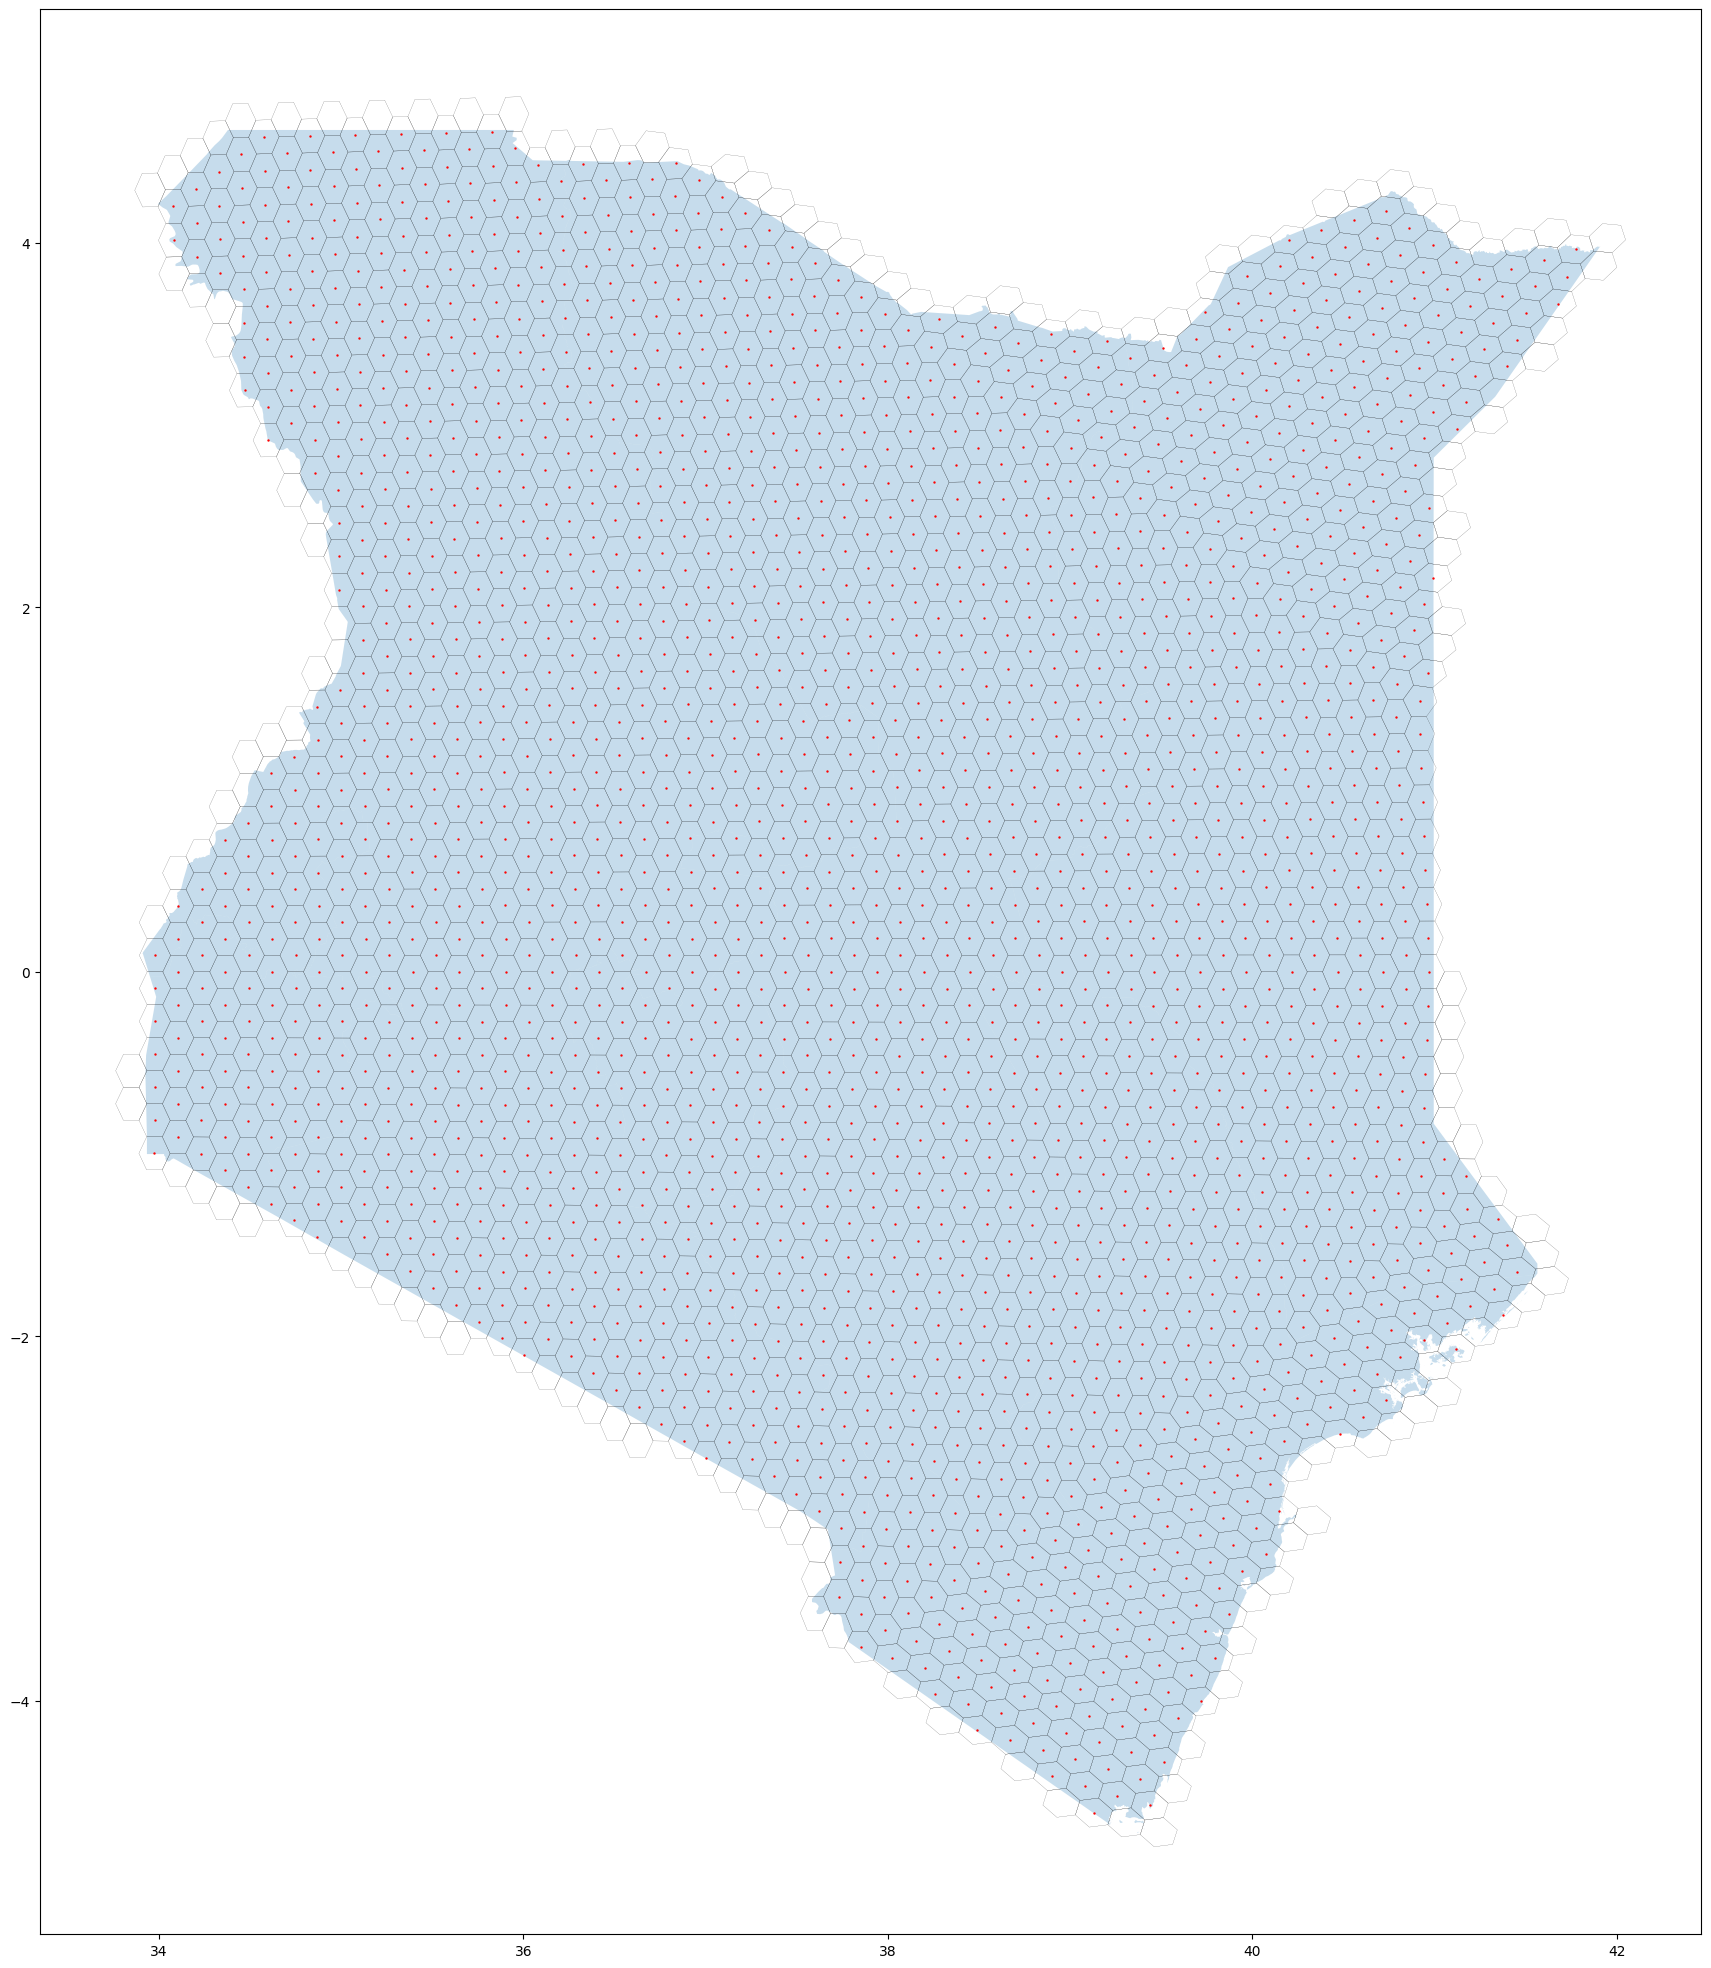

In [6]:
grid.plot_samples(aoi, hex_samples_gdf, hex_grid_cells)

### 3 - Creating a set of irregular sample points based on random and stratified sampling

#### 3.1 - Create points

In [ ]:
if not isinstance(aoi, ee.FeatureCollection):
    aoi = geemap.geopandas_to_ee(aoi.dissolve())

# stratified sampling based on ESA LC
imageCollection = ee.ImageCollection("ESA/WorldCover/v100")
esaLc = ee.Image(imageCollection.filterBounds(aoi).mosaic().clip(aoi).copyProperties(imageCollection.first()))

stratified_samples = esaLc.stratifiedSample(**{
    "numPoints": 25,
    "region": aoi,
    "scale": 100, 
    "seed": 42, 
    "tileScale": 4, 
    "geometries": True
}).map(h.set_id)

random_samples = ee.FeatureCollection.randomPoints(**{
    "points": 250,
    "region": aoi,
}).map(h.set_id)

random_samples Display in map

**Execute only**

In [ ]:
# intialize Map
Map = SepalMap(['HYBRID'])
Map.zoom_ee_object(aoi.geometry())

# add layers
Map.addLayer(ee.Image().byte().paint(featureCollection=aoi, color=1, width=3), {"palette": "blue"}, 'Area of interest')
Map.addLayer(esaLc, {}, 'ESA Worldcover 2020')
Map.addLayer(stratified_samples.draw(color="green", pointRadius=2), {}, 'Stratified Samples per class from ESA LC')
Map.addLayer(random_samples.draw(color="red", pointRadius=2), {}, 'Random Samples per class from ESA LC')

#
Map

### 4- Save outputs

The notebook allows you to export the final grid in 3 different ways:
1. Collect Earth Online  (comma-separated-value format)
2. GIS-vector file       (geopackage format)
3. Earth Engine Asset    (Feature Collection format)

In [8]:
from sampling_handler.misc.py_helpers import save_gdf_locally
from sampling_handler.misc.ee_helpers import export_to_ee

#------------------------
# define an outputs 
#------------------------

# select on of the above created grids that you want to save
final_samples = hex_samples_gdf
#hex_grid_cells.to_file('results/hex_cells_car.gpkg', driver='GPKG')
# directory where output files will go
outdir = '02_sample_design/' # if left ot None, it goes into module results

# output a CEO compatible csv file
out_ceo_csv = True

# output a Geopackage file
out_gpkg = True

# ee asset
ee_asset_name = '01_myproject_sbae_points'

# upload to EE
#export_to_ee(final_samples, ee_asset_name)

# save to local output directory
from sampling_handler.misc.py_helpers import save_gdf_locally
save_gdf_locally(final_samples, ceo_csv=out_ceo_csv, gpkg=out_gpkg, outdir=outdir)

INFO:  Saving outputs to 02_sample_design
